In [17]:
import pandas as pd
import numpy as np
import matplotlib as mtp
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
import tensorflow as tf

# **Load image's path and mask's path**

In [18]:
from glob import glob
mask_files = glob('D:/xampp/htdocs/practice/final year project/archive1/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

img_paths = [m.replace('_mask','') for m in mask_files]

# **Data Visualization**

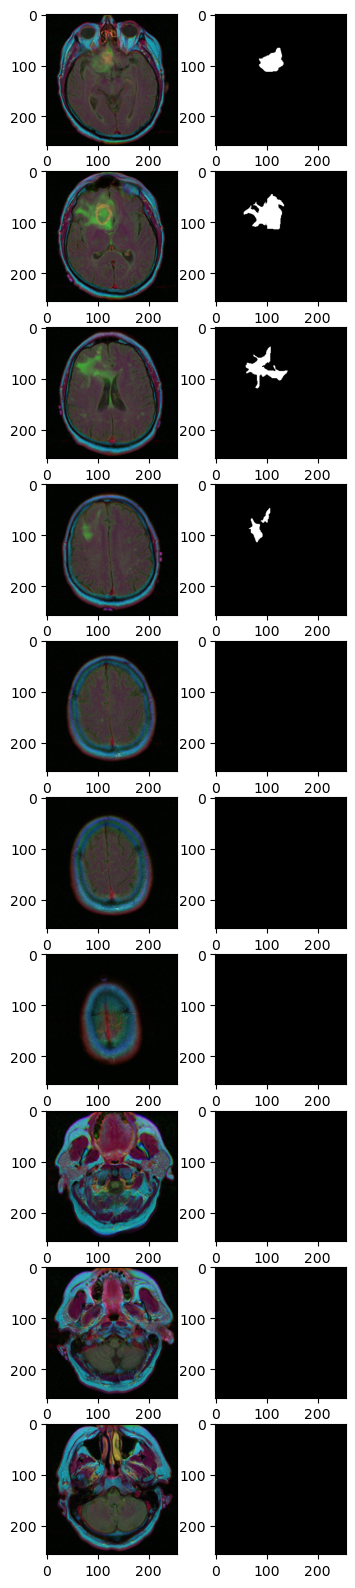

In [19]:
import cv2

rows, cols = 10, 2

fig = plt.figure(figsize = (4, 20))
for i in range(1, rows*cols, 2):
    
    fig.add_subplot(rows, cols, i)
    img = cv2.imread(img_paths[i])
    plt.imshow(img)

    fig.add_subplot(rows, cols, i+1)
    msk = cv2.imread(mask_files[i])
    plt.imshow(msk)


# **Create data frame and split data on train set, validation set and test set**

In [20]:
mri_df = pd.DataFrame({'img':img_paths,
                       'msk':mask_files})
mri_df.head()

,img,msk
0,D:/xampp/htdocs/practice/final year project/ar...,D:/xampp/htdocs/practice/final year project/ar...
1,D:/xampp/htdocs/practice/final year project/ar...,D:/xampp/htdocs/practice/final year project/ar...
2,D:/xampp/htdocs/practice/final year project/ar...,D:/xampp/htdocs/practice/final year project/ar...
3,D:/xampp/htdocs/practice/final year project/ar...,D:/xampp/htdocs/practice/final year project/ar...
4,D:/xampp/htdocs/practice/final year project/ar...,D:/xampp/htdocs/practice/final year project/ar...


# **Data genertator, data augmentation and adjust data**

In [21]:
from sklearn.model_selection import train_test_split

mri_df_train, mri_df_test = train_test_split(mri_df, test_size = 0.1,random_state=77_47)
mri_df_train, mri_df_val = train_test_split(mri_df_train, test_size = 0.1,random_state=77_47)

mri_df_train = mri_df_train.reset_index(drop=True)
mri_df_val = mri_df_val.reset_index(drop=True)
mri_df_test = mri_df_test.reset_index(drop=True)

# **Define loss function and metrics**

In [22]:
print(mri_df_train.shape,
      mri_df_val.shape,
      mri_df_test.shape)

(3182, 2) (354, 2) (393, 2)


# **Define Unet**

In [23]:
from keras.preprocessing.image import ImageDataGenerator

# assuming an human precision of 1% for manual tasks, so I'll use 2% for a safaty error margin
BATCH_SIZE = 32

def transformator(df,
                  rotation_range=0.2,
                  width_shift_range=0.02,
                  height_shift_range=0.02,
                  shear_range=0.1,
                  zoom_range=0.1,
                  horizontal_flip=True,
                  IMG_SIZE_TRAIN = (128,128),
                  BATCH_SIZE = 32):
    img_datag = ImageDataGenerator(
                rotation_range=rotation_range,
                width_shift_range=width_shift_range,
                height_shift_range=height_shift_range,
                shear_range=shear_range,
                zoom_range=zoom_range,
                horizontal_flip=True,
                fill_mode='nearest')
    msk_datag = ImageDataGenerator(
                rotation_range=rotation_range,
                width_shift_range=width_shift_range,
                height_shift_range=height_shift_range,
                shear_range=shear_range,
                zoom_range=zoom_range,
                horizontal_flip=True,
                fill_mode='nearest')

    img_generated = img_datag.flow_from_dataframe(
                      df,
                      x_col = 'img',
                      class_mode = None,
                      color_mode = 'rgb',
                      target_size = IMG_SIZE_TRAIN,
                      batch_size = BATCH_SIZE,
                      save_to_dir = None,
                      save_prefix = 'image',
                      seed = 777447)
    msk_generated = msk_datag.flow_from_dataframe(
                      df,
                      x_col='msk',
                      class_mode=None,
                      color_mode='grayscale',
                      target_size=IMG_SIZE_TRAIN,
                      batch_size=BATCH_SIZE,
                      save_to_dir=None,
                      save_prefix='mask',
                      seed=777447)

    generated = zip(img_generated, msk_generated)

    for img, msk in generated:
        img = img / 255
        msk = msk / 255

        msk[msk > 0.5] = 1
        msk[msk <= 0.5] = 0
        yield (img,msk)
data_train = transformator(mri_df_train)
data_val = transformator(mri_df_val)
data_test = transformator(mri_df_test)

In [24]:
import keras.layers as ls
import keras

inp = ls.Input((128,128,3))

c1 = ls.Conv2D(32, (3, 3),padding='same')(inp)
b1 = ls.Activation('relu')(c1)
c1 = ls.Conv2D(32, (3, 3), padding='same')(b1)
b1 = ls.BatchNormalization(axis=3)(c1)
b1 = ls.Activation('relu')(b1)
p1 = ls.MaxPooling2D(pool_size=(2, 2))(b1)

c2 = ls.Conv2D(64, (3,3),padding='same')(p1)
b2 = ls.Activation('relu')(c2)
c2 = ls.Conv2D(64, (3, 3), padding='same')(b2)
b2 = ls.BatchNormalization(axis=3)(c2)
b2 = ls.Activation('relu')(b2)
p2 = ls.MaxPooling2D(pool_size=(2, 2))(b2)

c3 = ls.Conv2D(128, (3,3),padding='same')(p2)
b3 = ls.Activation('relu')(c3)
c3 = ls.Conv2D(128, (3, 3), padding='same')(b3)
b3 = ls.BatchNormalization(axis=3)(c3)
b3 = ls.Activation('relu')(b3)
p3 = ls.MaxPooling2D(pool_size=(2, 2))(b3)
c4 = ls.Conv2D(256, (3,3),padding='same')(p3)
b4 = ls.Activation('relu')(c4)
c4 = ls.Conv2D(256, (3, 3), padding='same')(b4)
b4 = ls.BatchNormalization(axis=3)(c4)
b4 = ls.Activation('relu')(b4)
p4 = ls.MaxPooling2D(pool_size=(2, 2))(b4)

c5 = ls.Conv2D(512, (3,3),padding='same')(p4)
b5 = ls.Activation('relu')(c5)
c5 = ls.Conv2D(512, (3, 3), padding='same')(b5)
b5 = ls.BatchNormalization(axis=3)(c5)
b5 = ls.Activation('relu')(b5)
p5 = ls.MaxPooling2D(pool_size=(2, 2))(b5)

u6 = ls.concatenate([ls.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(b5), c4], axis=3)
c6 = ls.Conv2D(256, (3, 3), padding='same')(u6)
b6 = ls.Activation('relu')(c6)
c6 = ls.Conv2D(256, (3, 3), padding='same')(b6)
b6 = ls.BatchNormalization(axis=3)(c6)
b6 = ls.Activation('relu')(b6)

u7 = ls.concatenate([ls.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(b6), c3], axis=3)
c7 = ls.Conv2D(128, (3, 3), padding='same')(u7)
b7 = ls.Activation('relu')(c7)
c7 = ls.Conv2D(128, (3, 3), padding='same')(b7)
b7 = ls.BatchNormalization(axis=3)(c7)
b7 = ls.Activation('relu')(b7)
u8 = ls.concatenate([ls.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(b7), c2], axis=3)
c8 = ls.Conv2D(64, (3, 3), padding='same')(u8)
b8 = ls.Activation('relu')(c8)
c8 = ls.Conv2D(64, (3, 3), padding='same')(b8)
b8 = ls.BatchNormalization(axis=3)(c8)
b8 = ls.Activation('relu')(b8)

u9 = ls.concatenate([ls.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(b8), c1], axis=3)
c9 = ls.Conv2D(32, (3, 3), padding='same')(u9)
b9 = ls.Activation('relu')(c9)
c9 = ls.Conv2D(32, (3, 3), padding='same')(b9)
b9 = ls.BatchNormalization(axis=3)(c9)
b9 = ls.Activation('relu')(b9)

c10 = ls.Conv2D(1, (1, 1), activation='sigmoid')(b9)

model = keras.Model(inputs=[inp],
                    outputs=[c10])


In [25]:
def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [26]:
import keras.backend as K

smooth=100

def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)

    intersec = K.sum(y_true * y_pred)
    mod_sum = K.sum(y_true) + K.sum(y_pred)

    return (2 * intersec + smooth) / (mod_sum + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersec = K.sum(y_true * y_pred)
    comb_area = K.sum(y_true + y_pred) - intersec

    return (intersec + smooth) / (comb_area + smooth)

def iou_loss(y_true, y_pred):
    return - iou(y_true, y_pred)

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

model.compile(optimizer = Adam(learning_rate=0.0001),
              loss = iou_loss,
              metrics=["binary_accuracy", iou, dice_coef])


history = model.fit(data_train,
                    steps_per_epoch=(len(mri_df_train) / BATCH_SIZE),
                    epochs=60,
                    callbacks=[ModelCheckpoint('unet_128_mri_seg.hdf5', verbose=1, save_best_only=True)],
                    validation_data = data_val,
                    validation_steps=len(mri_df_val) / BATCH_SIZE)

Found 3182 validated image filenames.
Found 3182 validated image filenames.
Epoch 1/60


In [ ]:
pip install tensorflow

In [ ]:
from keras.optimizers import Adam